In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

from tqdm import tqdm

#### Features and targets

In [2]:
df = pd.read_csv('Data/df_final.csv')

y = df['measured log(solubility:mol/L)']
x = df.iloc[:,5:]

In [3]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled.shape

(1144, 161)

In [4]:
dataT = torch.tensor(x_scaled).float()
labels = torch.tensor(y).float()

Splitting the data into *training*, *validation*, and *testing* sets. Since hyperparameter tuning introduces bias into the model, the validation set is used to identify the best model, while the test set evaluates its true performance.

In [5]:
# train-val-test split 
x_train, x_temp, y_train, y_temp = train_test_split(dataT, labels, test_size=0.2, random_state=420)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=420)

# PyTorch Datasets
train_data = TensorDataset(x_train, y_train)
val_data = TensorDataset(x_val, y_val)
test_data = TensorDataset(x_test, y_test)

# DataLoader objects
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=val_data.tensors[0].shape[0])
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

#### Model

Testing various model architectures by varying **n_units** and **n_layers** to gain insights into the optimal design. All models will utilize the *ReLU* activation function, and architectures with more than three layers will include a **dropout layer** with a 30% probability.

In [6]:
class SolModel(nn.Module):
    def __init__(self, n_units, n_layers):
        super().__init__()

        # dict to store layers
        self.layers = nn.ModuleDict()
        self.n_layers = n_layers

        self.n_layers = n_layers

        # input layer
        self.layers['input'] = nn.Linear(161, n_units)

        # hidden layers
        for i in range(n_layers):
            self.layers[f'hidden_{i+1}'] = nn.Linear(n_units, n_units)
            
            # dropout layer for models with more than 3 layers
            if self.n_layers > 3 and i == 0:
                 self.dropout = nn.Dropout(p=0.3)

        # output layer
        self.layers['output'] = nn.Linear(n_units, 1)

    def forward(self, x):
        # input
        x = self.layers['input'](x)

        # hiddens
        for i in range(self.n_layers):
            x = F.relu(self.layers[f'hidden_{i+1}'](x))

            if self.n_layers > 3 and i == 0:
                x = self.dropout(x)

        # output
        return self.layers['output'](x)

In [7]:
device = torch.device('cuda')
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

Creating a function that initializes the model, loss function, and optimizer, and moves them to the GPU. **Mean Squared Error (MSE)** will be used as the loss function, and **Adam** will be the optimizer.

In [8]:
def createSolModel(n_units, n_layers):
    model = SolModel(n_units, n_layers)
    model.to(device)
    
    loss_func = nn.MSELoss()
    loss_func = loss_func.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    return model, loss_func, optimizer


A function to train the model and return R² scores, running for 100 epochs while evaluating the model's performance.

In [9]:
def train_model(n_units, n_layers):
    num_epochs = 100
    
    model, loss_func, optimizer = createSolModel(n_units, n_layers)

    # storing scores for each epoch
    train_r2_scores = []  
    val_r2_scores = []

    # trainig in epochs
    for epoch in range(num_epochs):

        y_train_actual, y_train_pred = [], []

        # training mode
        model.train()  

        # loop over batches
        for X_batch, y_batch in train_loader:
            # gpu
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

            # forward pass
            y_hat = model(X_batch)
            loss = loss_func(y_hat, y_batch)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # store predictions
            y_train_pred.extend(y_hat.detach().cpu().numpy().flatten())
            y_train_actual.extend(y_batch.cpu().numpy().flatten())

        # compute train R2 and store it
        train_r2 = r2_score(y_train_actual, y_train_pred)
        train_r2_scores.append(train_r2)

        # eval mode
        model.eval()
        y_val_actual, y_val_pred = [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
                y_hat = model(X_batch)

                # store predictions
                y_val_pred.extend(y_hat.cpu().numpy().flatten())
                y_val_actual.extend(y_batch.cpu().numpy().flatten())

        # compute validation R2 and store it
        val_r2 = r2_score(y_val_actual, y_val_pred)
        val_r2_scores.append(val_r2) 

    return train_r2_scores, val_r2_scores

### Experiment

Setting the number of layers between 1 and 6, with units per layer ranging from 100 to 600 in increments of 50. Storing the R² scores for both training and validation.

In [10]:
# model parameters
n_layers = range(1, 7)
n_units = np.arange(100, 601, 50)

# initialize output matrices
results = np.zeros((2, len(n_units), len(n_layers)))

# start the experiment
for unit_idx in tqdm(range(len(n_units))):
    for layer_idx in range(len(n_layers)):
        # create and train the model
        train_r2_scores, val_r2_scores = train_model(n_units[unit_idx], n_layers[layer_idx])

        # store the results
        results[0, unit_idx, layer_idx] = np.mean(train_r2_scores)
        results[1, unit_idx, layer_idx] = np.mean(val_r2_scores)
        

100%|██████████| 11/11 [08:15<00:00, 45.05s/it]


### Plotting results

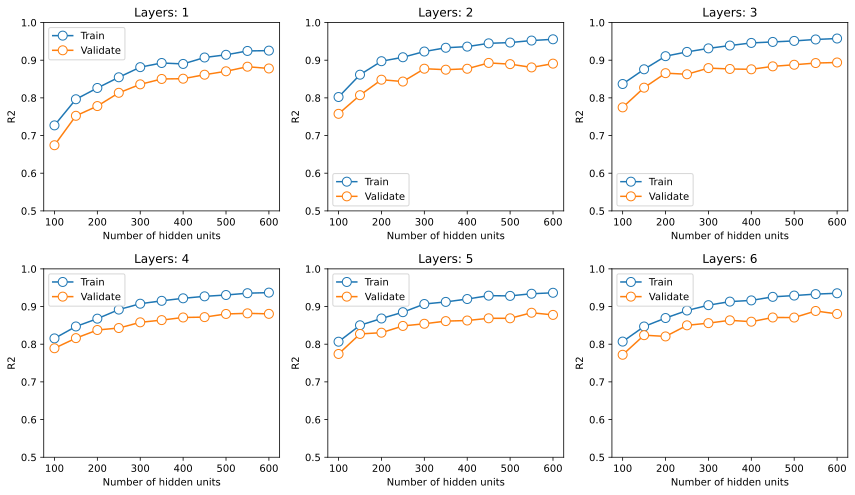

In [11]:
# show accuracy as a function of model depth
fig, ax = plt.subplots(2, 3, figsize=(12,7))
ax = ax.flatten()

for i in range(6):
    ax[i].plot(n_units, results[0,:,i:i+1], 'o-', markerfacecolor='w', markersize=9)
    ax[i].plot(n_units, results[1,:,i:i+1], 'o-', markerfacecolor='w', markersize=9)
    ax[i].legend(["Train", "Validate"])
    ax[i].set_xlabel('Number of hidden units')
    ax[i].set_ylabel('R2')
    ax[i].set_ylim(0.5, 1)
    ax[i].set_title(f'Layers: {i+1}')

plt.tight_layout()
plt.show()

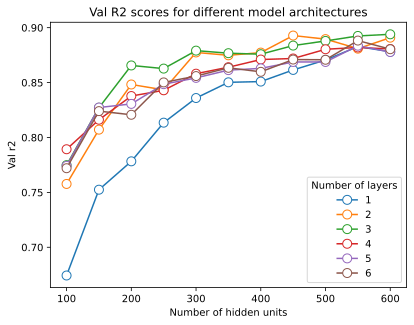

In [12]:
plt.plot(n_units, results[1,:,:], 'o-', markerfacecolor='w', markersize=9)
plt.legend(n_layers, title='Number of layers')
plt.title('Val R2 scores for different model architectures')
plt.xlabel('Number of hidden units')
plt.ylabel('Val r2')
plt.show()

Increasing the number of layers beyond 2 does not significantly improve model performance, but increasing the number of units per layer tends to give better results.

### Testing different activation functions

In [50]:
class TestModel(nn.Module):
    def __init__(self, act_func):
        super().__init__()

        self.act_func = act_func

        # input layer
        self.input = nn.Linear(161, 450)

        # hiddeb layers
        self.fc1 = nn.Linear(450, 450)
        self.fc2 = nn.Linear(450, 450)

        # output layer
        self.output = nn.Linear(450, 1)

    def forward(self, x):

        act_func = getattr(F, self.act_func)

        x = self.input(x)
        
        x = act_func(self.fc1(x))
        x = act_func(self.fc2(x))

        return self.output(x)
        

In [51]:
def train_test_model(act_func):
    num_epochs = 100

    model = TestModel(act_func)
    model.to(device)
    
    loss_func = nn.MSELoss()
    loss_func = loss_func.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    losses = torch.zeros(num_epochs)
    val_r2_scores = []

    for epoch in range(num_epochs):
        model.train()

        batch_loss = []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
            # forward pass
            y_hat = model(X_batch)
            loss = loss_func(y_hat, y_batch)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

        losses[epoch] = np.mean(batch_loss)

        model.eval()

        y_val_actual, y_val_pred = [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
                y_hat = model(X_batch)

                # store predictions
                y_val_pred.extend(y_hat.cpu().numpy().flatten())
                y_val_actual.extend(y_batch.cpu().numpy().flatten())

        # compute validation R2 and store it
        val_r2 = r2_score(y_val_actual, y_val_pred)
        val_r2_scores.append(val_r2) 

    return losses, val_r2_scores     

In [52]:
activation_funcs = ['relu', 'relu6', 'leaky_relu', 'tanh', 'sigmoid']

val_by_act = np.zeros((100, len(activation_funcs)))
losses = np.zeros((100, len(activation_funcs)))

for act_idx, act_fun in enumerate(activation_funcs):
    losses[:, act_idx], val_by_act[:, act_idx] = train_test_model(act_fun)

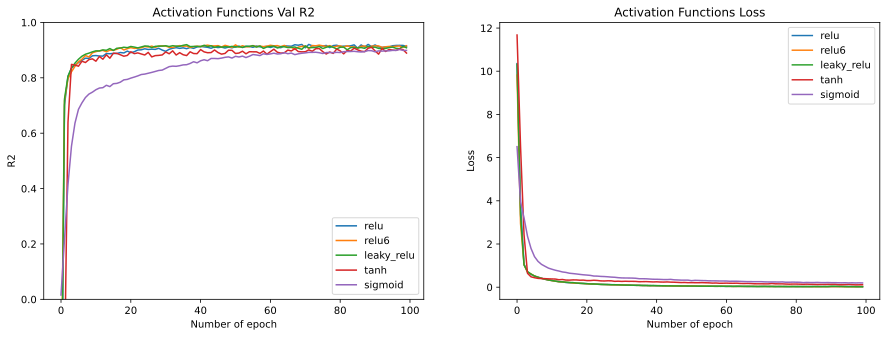

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(val_by_act)
ax[0].set_title('Activation Functions Val R2')
ax[0].set_ylabel('R2')
ax[0].set_ylim([0, 1])

ax[1].plot(losses)
ax[1].set_title('Activation Functions Loss')
ax[1].set_ylabel('Loss')

for i in range(2):
    ax[i].legend(activation_funcs)
    ax[i].set_xlabel('Number of epoch')

plt.show()